# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY ĐỂ DỰ ĐOÁN GIÁ NÔNG SẢN

Sinh viên 1: Huỳnh Hạo Nhị - 20133006

Sinh viên 2: Võ Hoài Thương - 20233012

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# Dữ liệu giá xoài

Dữ liệu giá xoài được thu thập của tỉnh An Giang, từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn từ năm 2007 đến nay.
*   date*: ngày
*   price: giá xoài


In [ ]:
df_mango = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xoai/gia_xoai.csv', encoding='ISO-8859-1')
df_mango.tail()

,date,price
1416,2024-05-06,30000
1417,2024-05-08,25000
1418,2024-05-10,25000
1419,2024-05-13,25000
1420,2024-05-14,25000


In [ ]:
df_mango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1421 non-null   object
 1   price   1421 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.3+ KB


In [ ]:
df_mango['date'] = pd.to_datetime(df_mango['date'])
df_mango.set_index('date', inplace=True)

## Điền dữ liệu ngày còn thiếu

In [ ]:
df_mango.shape

(1421, 1)

In [ ]:
idx = pd.date_range(df_mango.index.min(), df_mango.index.max())
df_mango = df_mango.reindex(idx)
df_mango.fillna(method='ffill', inplace=True)
df_mango.tail()

,price
2024-05-10,25000.0
2024-05-11,25000.0
2024-05-12,25000.0
2024-05-13,25000.0
2024-05-14,25000.0


In [ ]:
df_mango.shape

(3464, 1)

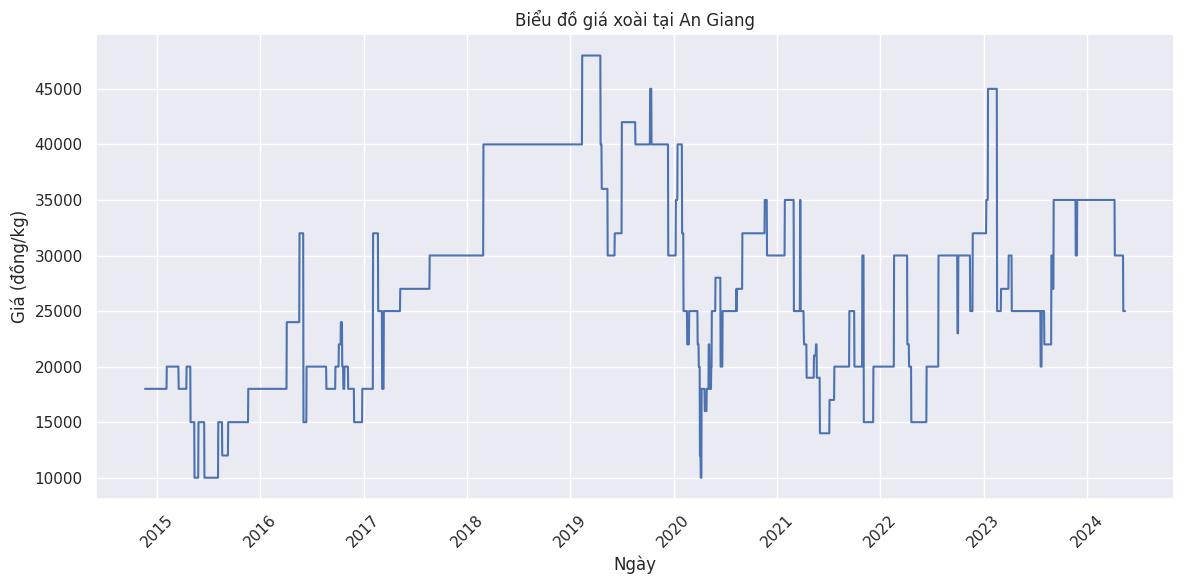

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_mango, x=df_mango.index, y='price')
plt.title('Biểu đồ giá xoài tại An Giang')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Làm mịn dữ liệu

In [ ]:
df_mango = df_mango.rolling(window=30, min_periods=1).mean()

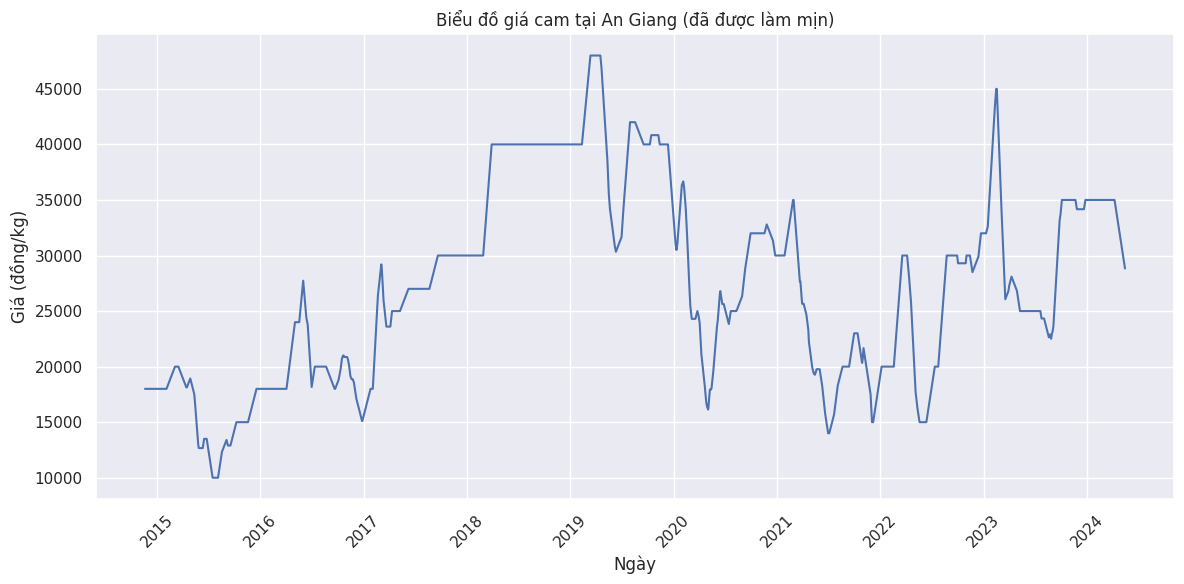

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_mango, x=df_mango.index, y='price')
plt.title('Biểu đồ giá xoài tại An Giang (đã được làm mịn)')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mô hình GRU dự đoán đơn biến

Gated Recurrent Unit (GRU)  là mạng nơ-ron hồi quy có khả năng xử lý chuỗi thời gian dài hạn, là biến thể đơn giản hóa từ Long Short-Term Memory (LSTM) với cấu trúc gồm hai cổng:
*   Cổng đặt lại (r): xác định phần thông tin của trạng thái ẩn trước cần loại bỏ bằng hàm sigmoid.
*   Cổng cập nhật (z): xác định thông tin nào từ trạng thái ẩn trước được giữ lại và thông tin mới nào sẽ được thêm vào bằng hàm sigmoid.
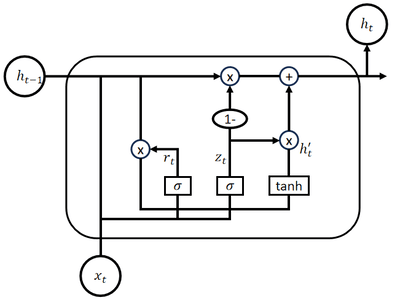

## Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(df_mango['price'].values.reshape(-1, 1))

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_price, seq_length)

In [ ]:
X.shape, y.shape

((3434, 30, 1), (3434, 1))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (2747, 30, 1) (2747, 1)
Kích thước tập kiểm tra: (687, 30, 1) (687, 1)


In [ ]:
model = Sequential()
model.add(GRU(units=128, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(GRU(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
43/43 [==============================] - 18s 164ms/step - loss: 0.0152
Epoch 2/50
43/43 [==============================] - 5s 125ms/step - loss: 0.0024
Epoch 3/50
43/43 [==============================] - 3s 76ms/step - loss: 0.0020
Epoch 4/50
43/43 [==============================] - 3s 76ms/step - loss: 0.0017
Epoch 5/50
43/43 [==============================] - 5s 124ms/step - loss: 0.0018
Epoch 6/50
43/43 [==============================] - 3s 76ms/step - loss: 0.0016
Epoch 7/50
43/43 [==============================] - 3s 76ms/step - loss: 0.0016
Epoch 8/50
43/43 [==============================] - 4s 87ms/step - loss: 0.0015
Epoch 9/50
43/43 [==============================] - 5s 108ms/step - loss: 0.0014
Epoch 10/50
43/43 [==============================] - 3s 76ms/step - loss: 0.0014
Epoch 11/50
43/43 [==============================] - 3s 76ms/step - loss: 0.0013
Epoch 12/50
43/43 [==============================] - 4s 104ms/step - loss: 0.0013
Epoch 13/50
43/43 [============

## Dự đoán tập train

In [ ]:
train_predictions = model.predict(X_train)

86/86 [==============================] - 2s 16ms/step


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 222.25
Training MAPE: 0.79%


In [ ]:
dates = df_mango.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá xoài trên tập huấn luyện (mô hình GRU)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Dự đoán tập test

In [ ]:
test_predictions = model.predict(X_test)

22/22 [==============================] - 0s 18ms/step


In [ ]:
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {train_mape:.2f}%')

Testing RMSE: 226.58
Testing MAPE: 0.79%


In [ ]:
dates = df_mango.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá xoài trên tập kiểm tra (mô hình GRU)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

## Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

            RMSE  MAPE (%)
0  Train  222.25      0.79
1   Test  226.58      0.50


## Lưu mô hình



In [ ]:
# model.save('GRU_gia_xoai.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

